In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare 

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

using functions created to acquire and wrangle the data

In [2]:
df = acquire.get_zillow_data()



In [ ]:
df.info()

In [3]:
df = prepare.remove_outliers(df)


In [4]:
df = prepare.handle_nulls(df)


In [5]:
df = prepare.rename_columns(df)


In [6]:
df = prepare.prepare_locs(df)

In [ ]:
df.info()

this looks good for now... let's think about some things to explore-

-curious to see if transaction date and log error have any relation, like does the time of year of transation increase/dec likelihood of error?

-let's look for like-things... how closely linked are bedroom and bathroom, could they be combined to one feature?

-what does the correlatoin to log error chart look like?

-what can we bin? keep this in mind through exploration.

-look at square feet and year together. do homes get bigger over time?

-what if we tried K means on lat, long and square feet?

-let's start here and keep adding ideas here when they come up

-look at pool

In [ ]:
df.propertycountylandusecode.value_counts()

In [7]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting


**Number of Train Records:** 26,843

**Number of Validate Records:** 11,505

**Number of Test Records:** 9,588

In [ ]:
train.propertycountylandusecode.value_counts()

In [8]:
train = train.where(train.propertycountylandusecode != '0109')
train = train.where(train.propertycountylandusecode != '0105')
train = train.where(train.propertycountylandusecode != '1112')
train = train.where(train.propertycountylandusecode != '0131')


In [9]:
train = train.dropna()

In [10]:
train['has_pool'] = train.has_pool.astype('uint8')

In [36]:
train['orange_L'] = (train['propertycountylandusecode'] == '1')
train['orange_M'] = (train['propertycountylandusecode'] == '122')

validate['orange_L'] = (validate['propertycountylandusecode'] == '1')
validate['orange_M'] = (validate['propertycountylandusecode'] == '122')

test['orange_L'] = (test['propertycountylandusecode'] == '1')
test['orange_M'] = (test['propertycountylandusecode'] == '122')

In [65]:
train['ventura_M'] = (train['propertycountylandusecode'] == '1111')
train['ventura_L'] = (train['propertycountylandusecode'] == '1110')

validate['ventura_M'] = (validate['propertycountylandusecode'] == '1111')
validate['ventura_L'] = (validate['propertycountylandusecode'] == '1110')

test['ventura_M'] = (test['propertycountylandusecode'] == '1111')
test['ventura_L'] = (test['propertycountylandusecode'] == '1110')

In [64]:
train['LA_M'] = (train['propertycountylandusecode'] == '0100') 
train['LA_S'] = (train['propertycountylandusecode'] == '010G') 
train['LA_S2'] = (train['propertycountylandusecode'] == '010M')

validate['LA_M'] = (validate['propertycountylandusecode'] == '0100') 
validate['LA_S'] = (validate['propertycountylandusecode'] == '010G')
validate['LA_S2'] = (validate['propertycountylandusecode'] == '010M')

test['LA_M'] = (test['propertycountylandusecode'] == '0100') 
test['LA_S'] = (test['propertycountylandusecode'] == '010G') 
test['LA_S2'] = (test['propertycountylandusecode'] == '010M')

In [66]:
train['LA_L'] = (train['propertycountylandusecode'] == '0101')
train['LA_L2'] = (train['propertycountylandusecode'] == '0103') 
train['LA_L3'] = (train['propertycountylandusecode'] == '0104')

validate['LA_L'] = (validate['propertycountylandusecode'] == '0101')
validate['LA_L2'] = (validate['propertycountylandusecode'] == '0103') 
validate['LA_L3'] = (validate['propertycountylandusecode'] == '0104')

test['LA_L'] = (test['propertycountylandusecode'] == '0101') 
test['LA_L2'] = (test['propertycountylandusecode'] == '0103') 
test['LA_L3'] = (test['propertycountylandusecode'] == '0104')

In [67]:
dummy = pd.get_dummies(train[['LA_L3', 'LA_L2', 'LA_S2', 'orange_L', 'orange_M', 'ventura_M', 'ventura_L', 'LA_S', 'LA_M', 'LA_L']])
dummy1 = pd.get_dummies(validate[['LA_L3','LA_L2', 'LA_S2','orange_L', 'orange_M', 'ventura_M', 'ventura_L', 'LA_S', 'LA_M', 'LA_L']])
dummy2 = pd.get_dummies(test[['LA_L3','LA_L2', 'LA_S2','orange_L', 'orange_M', 'ventura_M', 'ventura_L', 'LA_S', 'LA_M', 'LA_L']])

In [ ]:
train['tsx'] = train[(train.propertycountylandusecode == '010G')]

In [ ]:
train['LA_S'] = train[(train.propertycountylandusecode == '0100')
train['LA_XS'] = train[(train.propertycountylandusecode == 010G) | (train.propertycountylandusecode == 010M)
                

In [ ]:
train['LA_S'] = train[train.propertycountylandusecode == '0100']
train['LA_L = train[train.propertycountylandusecode == '1110']
train['LA_M = train[train.propertycountylandusecode == '1111']
train['LA_L = train[train.propertycountylandusecode == '1110']

In [ ]:
orange_L.garages.min()

In [ ]:
orange = train.where(train.county == 'orange')

In [ ]:
orange= orange.dropna()

In [ ]:
orange.info()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = train.drop(['log_error'], axis=1).corrwith(train['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='square_feet', y='log_error', data=train, scatter=True, hue='county', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by County) to Log Error")

I feel like it would make more sense to use absolute value of log error as we don't want a high or low, we want it close to 0. I'll make a new column and try some exploration with that

In [ ]:
train['abs_LE'] = train.log_error.abs()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = train.drop(['abs_LE', 'log_error'], axis=1).corrwith(train['abs_LE']).sort_values().plot.barh()
corr_chart

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='square_feet', y='abs_LE', data=train, scatter=True, hue='county', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by County) to Log Error")

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='square_feet', y='abs_LE', data=train, scatter=True, col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by County) to Log Error")

ok thinking about this more, I don't think we can use the abs value b/c log error -3 may have a different strength in error (skewed) than log error 3. However, I do want to look at pos and neg error separately and see if there are patterns there. Let's try that

In [ ]:
#actually, let's create 2 dfs to try this

In [ ]:
postrain = train.copy().where(train.log_error > 0)

In [ ]:
postrain = postrain.dropna()

In [ ]:
negtrain = train.copy().where(train.log_error < 0)
negtrain = negtrain.dropna()

In [ ]:
postrain.head()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = postrain.drop(['abs_LE', 'log_error'], axis=1).corrwith(postrain['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = negtrain.drop(['abs_LE', 'log_error'], axis=1).corrwith(negtrain['log_error']).sort_values().plot.barh()
corr_chart

square footage is a strong corr when neg and pos are together, but not individually. what does that say?

ok, let's think about this... what happens leading to a positive log error?

logerror = log(Zestimate) - log(SalePrice)

so just to make this simple, let's say the predicted(zest) is $10,000, but the sale price was 8,000. The prediction was OVER

10,000 - 8,000 = positive log error.

If that was flipped, the error would be negative. So-

### POSITIVE LOG ERROR - Pred TOO HIGH

### NEGATIVE LOG ERROR -Pred TOO LOW

sooo... going back to square feet. square feet may cause the prediction to be high or low, but if we are focused in on high or low predictions... ok let's think of an example

house has 2500 square feet and based on corr with tax value, the ML algothrim predicts this home is 200,000. Actually this home is 300,000.
So, wait, we are looking at features that cause the predictions to be wrong? right? B/c w square feet, maybe if we also took into account the year built, it would shift that prediction. So, I think we need to look at features that impact features here...

so square feet, what also impacts that?

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = train.drop(['abs_LE', 'square_feet', 'log_error'], axis=1).corrwith(train['square_feet']).sort_values().plot.barh()
corr_chart

Now we are cooking with gas! Look at that strong correlation! Let's back that up with a stats test

In [ ]:
alpha = .05
# setting alpha to aid in determining statistical significance 

x = train.square_feet
y = train.bathrooms
# creates short variable assignments 

corr, p = stats.pearsonr(x, y)
# creates variables for the r value and the p value respectively 

if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

corr, p

#WOW! strong correlation here!

could we group these together w Kmeans?

In [ ]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train[['bathrooms', 'bedrooms', 'square_feet']])
# inserts the 4 selected features into the scaler

train[['scalbathrooms', 'scalbedrooms', 'scalsquare_feet']] = scaler.transform(train[['bathrooms', 'bedrooms', 'square_feet']])

In [ ]:
X = train[['scalbathrooms', 'scalbedrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

kmeans.predict(X)

train['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = train.drop(['log_error', 'abs_LE'], axis=1).corrwith(postrain['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
plt.figure(figsize=(15, 8))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.scalbathrooms, subset.scalsquare_feet, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='scalbathrooms', x='scalsquare_feet', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.title('Visualizing Cluster Centers')

In [ ]:
train['cluster'].head()

In [ ]:
train.head()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = train.drop(['log_error'], axis=1).corrwith(train['log_error']).sort_values().plot.barh()
corr_chart

new idea... let's try to break up data by property size...

In [ ]:
train.square_feet.quantile(1)

In [ ]:
small = train.copy().where(train.square_feet < 1423)
small = small.dropna()

In [ ]:
med = train.copy().where((train.square_feet >= 1423) & (train.square_feet < 1988))
med = med.dropna()

In [ ]:
small

In [ ]:
large = train.copy().where((train.square_feet >= 1988))
large = large.dropna()

In [ ]:
large

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = large.drop(['log_error', 'abs_LE'], axis=1).corrwith(large['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = small.drop(['log_error', 'abs_LE'], axis=1).corrwith(small['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = med.drop(['log_error', 'abs_LE'], axis=1).corrwith(med['log_error']).sort_values().plot.barh()
corr_chart

The clusters are fantastic for medium homes. I wonder if we made more groups for size...

In [ ]:
train.square_feet.quantile(.33)

In [ ]:
xsmall = train.copy().where(train.square_feet < 1184)
xsmall = small.dropna()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = xsmall.drop(['log_error', 'abs_LE'], axis=1).corrwith(xsmall['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
small = train.copy().where((train.square_feet >= 1184) & (train.square_feet < 1393))
small = small.dropna()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = small.drop(['log_error', 'abs_LE'], axis=1).corrwith(small['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
train.square_feet.quantile(.84)

In [ ]:
xlarge = train.copy().where(train.square_feet >= 4000)
xlarge = large.dropna()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = xsmall.drop(['log_error', 'abs_LE'], axis=1).corrwith(xsmall['log_error']).sort_values().plot.barh()
corr_chart

OK, so looks like the cluster of square feet and bathrooms show great corr with log erro for xs through med homes. we need something else for large and xlarge. First, I want to add bed to these to see what happsn. I mean take out.

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = train.drop(['log_error', 'year_built', 'abs_LE'], axis=1).corrwith(train['year_built']).sort_values().plot.barh()
corr_chart

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train[['bathrooms', 'year_built', 'square_feet']])
# inserts the 4 selected features into the scaler

train[['scalbathrooms', 'scalyear', 'scalsquare_feet']] = scaler.transform(train[['bathrooms', 'year_built', 'square_feet']])

In [ ]:
X = train[['scalbathrooms', 'scalyear', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

kmeans.predict(X)

train['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = train.drop(['log_error', 'abs_LE'], axis=1).corrwith(train['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
xlarge = train.copy().where(train.square_feet >= 2000)
xlarge = large.dropna()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = xlarge.drop(['log_error', 'abs_LE', 'cluster'], axis=1).corrwith(xlarge['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
train.info()

In [ ]:
train.bathrooms.astype(int)

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
X = [['bathrooms', 'year_built', 'lot_size', 'garage_size', 'square_feet', 'bedrooms']]
# inserts the 4 selected features into the scaler


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=8)

# find the top 8 X's correlated with y
f_selector.fit(X, train.log_error)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [ ]:
train[['scalbathrooms', 'scalyear', 'scalsquare_feet']] = scaler.transform(train[['bathrooms', 'year_built', 'square_feet']])

I want to explore potential similaries between pos high and neg low logs and features

In [ ]:
postrain = train.copy().where(train.log_error > 0)
postrain = postrain.dropna()
negtrain = train.copy().where(train.log_error < 0)
negtrain = negtrain.dropna()

In [ ]:
negtrain

In [ ]:
negtrain.log_error.quantile(.9)

In [ ]:
high = postrain.copy().where(train.log_error > .05)
high = high.dropna()

In [ ]:
low = negtrain.copy().where(train.log_error < -0.0099)
low = low.dropna()

In [ ]:
high

In [ ]:
high.year_built.mean(), train.year_built.mean()

In [ ]:
high.bedrooms.mean(), train.bedrooms.mean()

In [ ]:
high.bathrooms.mean(), train.bathrooms.mean()

In [ ]:
low.square_feet.mean(), train.square_feet.mean() ### look at this for low and high

In [ ]:
low.columns

In [ ]:
low.fips.value_counts(), train.fips.value_counts()

In [ ]:
high.garages.mean(), train.garages.mean() ### maybe for high & low

In [ ]:
high.has_pool.mean(), train.has_pool.mean() #possible low

In [ ]:
high.lot_size.mean(), train.lot_size.mean() #lot size high

In [ ]:
low.garage_size.mean(), train.garage_size.mean() ### look at high and low

In [ ]:
low.transaction_date.mean(), train.transaction_date.mean()

In [ ]:
low.cluster.mean(), train.cluster.mean()

In [ ]:
high.square_feet.mean(), train.square_feet.mean()

so higher square footage may make error on the high side and vv

In [ ]:
high.square_feet.mean()

In [ ]:
train

In [ ]:
xsmall

In [ ]:
xsmall

In [ ]:
xsmall = train.copy().where(train.square_feet < 1184)
xsmall = xsmall.dropna()

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = xsmall.drop(['log_error', 'abs_LE', 'cluster'], axis=1).corrwith(xsmall['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

kmeans = KMeans(
    init="random",
    n_clusters=8)

coords = xsmall[['latitude', 'longitude']].to_numpy()

coords = xsmall[['latitude', 'longitude']].to_numpy()

kmeans.fit(coords)

kmeans.predict(coords)

xsmall['loca'] = kmeans.predict(coords)

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(coords).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 20))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
xsmall = xsmall.where(xsmall.bedrooms >= 2)
xsmall = xsmall.dropna()
xsmall

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = xsmall.drop(['log_error', 'abs_LE', 'cluster'], axis=1).corrwith(xsmall['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
data = xsmall[['loca', 'propertycountylandusecode', 'has_pool', 'garage_size', 'garages', 'bathrooms', 'lot_size', 'year_built', 'bedrooms', 'square_feet']]

In [ ]:
data

In [ ]:
sns.pairplot(data)

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = data.corrwith(xsmall['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
data.loca

In [ ]:
alpha = .05
x = data.has_pool
y = data.loca
corr, p = stats.pearsonr(x, y)
if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
corr, p

In [ ]:
alpha = .05
x = data.square_feet
y = data.garage_size
corr, p = stats.pearsonr(x, y)
if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
corr, p

In [ ]:
alpha = .05
x = data.square_feet
y = data.garages
corr, p = stats.pearsonr(x, y)
if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
corr, p

In [ ]:
alpha = .05
x = data.square_feet
y = data.bedrooms
corr, p = stats.pearsonr(x, y)
if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
corr, p

In [ ]:
alpha = .05
x = data.square_feet
y = data.bathrooms
corr, p = stats.pearsonr(x, y)
if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
corr, p

In [ ]:
alpha = .05
x = data.square_feet
y = data.square_feet
corr, p = stats.pearsonr(x, y)
if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
corr, p

In [ ]:
alpha = .05
x = data.square_feet
y = data.lot_size
corr, p = stats.pearsonr(x, y)
if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
corr, p

In [ ]:
alpha = .05
x = data.square_feet
y = data.year_built
corr, p = stats.pearsonr(x, y)
if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
corr, p

In [ ]:
alpha = .05 

s1 = data[data.has_pool == 1].lot_size
s2 = data.lot_size.mean()

t, p = stats.ttest_1samp(s1, s2)

print(t, p, alpha)

if p > alpha:
    print("We fail to reject the null hypothesis")
elif t < 0:
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

In [ ]:
data.info()

In [ ]:
sns.barplot(data=data, x='propertycountylandusecode', y='lot_size')
plt.title("Churn and Average Tenure in Months")

In [ ]:
df[df.propertycountylandusecode == '0109'].mean().round()

In [ ]:
df.propertycountylandusecode.value_counts()

In [ ]:
train = pd.concat([train, dummy3], axis=1)

In [69]:
data = train[['bathrooms', 'bedrooms', 'square_feet', 'garages', 'garage_size', 'lot_size']]

In [70]:
dummy

,LA_L3,LA_L2,LA_S2,orange_L,orange_M,ventura_M,ventura_L,LA_S,LA_M,LA_L
25090,False,False,False,False,False,False,False,False,True,False
2396,False,False,False,False,False,False,False,False,True,False
18215,False,False,False,False,False,False,False,False,True,False
4413,False,False,False,False,False,False,False,False,True,False
4538,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
51804,False,False,False,False,False,False,False,False,True,False
9094,False,False,False,False,False,False,False,False,False,True
7527,False,False,False,False,True,False,False,False,False,False
50318,False,False,False,False,True,False,False,False,False,False


In [71]:
dummy = dummy.astype('int')

In [72]:
scaler = sklearn.preprocessing.MinMaxScaler()
# employs the min max scaler
scaler.fit(data)

MinMaxScaler()

In [73]:
v = scaler.transform(data)

In [74]:
v = pd.DataFrame(data = v)

In [75]:
v.index = data.index

In [93]:
X_train = pd.concat([dummy, v], axis=1)

In [94]:
X_train

,LA_L3,LA_L2,LA_S2,orange_L,orange_M,ventura_M,ventura_L,LA_S,LA_M,LA_L,0,1,2,3,4,5
25090,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.155464,0.000000,0.000000,0.000882
2396,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.095258,0.000000,0.000000,0.000712
18215,0,0,0,0,0,0,0,0,1,0,0.00,0.25,0.099381,0.000000,0.000000,0.000981
4413,0,0,0,0,0,0,0,0,1,0,0.75,1.00,0.455258,0.000000,0.000000,0.000855
4538,0,0,0,0,0,0,0,0,1,0,0.25,0.50,0.291753,0.000000,0.000000,0.000954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51804,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.098144,0.000000,0.000000,0.000856
9094,0,0,0,0,0,0,0,0,0,1,0.25,0.50,0.145979,0.000000,0.000000,0.001007
7527,0,0,0,0,1,0,0,0,0,0,0.25,0.50,0.255464,0.142857,0.094096,0.001128
50318,0,0,0,0,1,0,0,0,0,0,0.25,0.75,0.165773,0.142857,0.106093,0.000783


In [78]:
#X_train = dummy
# creates dataframe that drops all column except the selected features for modeling
y_train = train[['log_error']]
# creates dataframe of target variable (y) only

# X_validate = dummy
# y_validate = validate[['log_error']]
# # repeat above for validate set

# X_test = dummy
# y_test = test[['log_error']]

In [44]:
X_train = X_train.astype('int')
X_validate = X_validate.astype('int')

In [79]:
y_train

,log_error
25090,-0.018411
2396,0.106983
18215,0.343834
4413,-0.036174
4538,0.019838
...,...
51804,0.028120
9094,0.020197
7527,0.011196
50318,-0.057559


In [90]:
y_train['pred_mean'] = y_train.log_error.mean()
#y_validate['pred_mean'] = y_validate.log_error.mean()
# calculates mean prior to computing rmse

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_mean)**(1/2)
#rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_mean)**(1/2)
# computes baseline RMSE for train and validate sets (square root of MSE)

print("Baseline RMSE\nTrain/In-Sample: ", (rmse_train)), 
#print("Baseline RMSE\nValidate/Out-of-Sample: ", (rmse_validate))

Baseline RMSE
Train/In-Sample:  0.08353491952815524


(None,)

In [97]:
lm = LinearRegression(normalize=True)
# create the model

lm.fit(X_train, y_train.log_error)
# fit the model to scaled training data

y_train['value_predict_lm'] = lm.predict(X_train)
# computes model predictions

rmse_train = mean_squared_error(y_train.log_error, y_train.value_predict_lm)**(1/2)
# computes model rmse

#y_validate['value_predict_lm'] = lm.predict(X_validate)
#rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_predict_lm)**(1/2)
# comutes predictions and rmse with validate data

printmd("**OLS Linear Regression Performance**")
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", (rmse_train))
print("---------------------------------------")
#print("RMSE for OLS using LinearRegression\nValidation/Out-of-Sample: ", (rmse_validate))

**OLS Linear Regression Performance**

---------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  0.08332682671635622
---------------------------------------


In [98]:
lars = LassoLars(alpha=1.0)
# creates the model

lars.fit(X_train, y_train.log_error)
# fit the model to scaled training data

y_train['pred_lars'] = lars.predict(X_train)
# computes model predictions
rmse_train = mean_squared_error(y_train.log_error, y_train.pred_lars)**(1/2)
# computes model rmse

# y_validate['pred_lars'] = lars.predict(X_validate)
# rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(1/2)
# comutes predictions and rmse with validate data

printmd("**LARS Performance**")
print("---------------------------------------")
print("RMSE for Lars\nTraining/In-Sample: ", round(rmse_train, 5))

**LARS Performance**

---------------------------------------
RMSE for Lars
Training/In-Sample:  0.08353


In [99]:
X_train

,LA_L3,LA_L2,LA_S2,orange_L,orange_M,ventura_M,ventura_L,LA_S,LA_M,LA_L,0,1,2,3,4,5
25090,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.155464,0.000000,0.000000,0.000882
2396,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.095258,0.000000,0.000000,0.000712
18215,0,0,0,0,0,0,0,0,1,0,0.00,0.25,0.099381,0.000000,0.000000,0.000981
4413,0,0,0,0,0,0,0,0,1,0,0.75,1.00,0.455258,0.000000,0.000000,0.000855
4538,0,0,0,0,0,0,0,0,1,0,0.25,0.50,0.291753,0.000000,0.000000,0.000954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51804,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.098144,0.000000,0.000000,0.000856
9094,0,0,0,0,0,0,0,0,0,1,0.25,0.50,0.145979,0.000000,0.000000,0.001007
7527,0,0,0,0,1,0,0,0,0,0,0.25,0.50,0.255464,0.142857,0.094096,0.001128
50318,0,0,0,0,1,0,0,0,0,0,0.25,0.75,0.165773,0.142857,0.106093,0.000783


In [100]:
X_train

,LA_L3,LA_L2,LA_S2,orange_L,orange_M,ventura_M,ventura_L,LA_S,LA_M,LA_L,0,1,2,3,4,5
25090,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.155464,0.000000,0.000000,0.000882
2396,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.095258,0.000000,0.000000,0.000712
18215,0,0,0,0,0,0,0,0,1,0,0.00,0.25,0.099381,0.000000,0.000000,0.000981
4413,0,0,0,0,0,0,0,0,1,0,0.75,1.00,0.455258,0.000000,0.000000,0.000855
4538,0,0,0,0,0,0,0,0,1,0,0.25,0.50,0.291753,0.000000,0.000000,0.000954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51804,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.098144,0.000000,0.000000,0.000856
9094,0,0,0,0,0,0,0,0,0,1,0.25,0.50,0.145979,0.000000,0.000000,0.001007
7527,0,0,0,0,1,0,0,0,0,0,0.25,0.50,0.255464,0.142857,0.094096,0.001128
50318,0,0,0,0,1,0,0,0,0,0,0.25,0.75,0.165773,0.142857,0.106093,0.000783


In [106]:
glm = TweedieRegressor(power= 1, alpha=1)
# creates the model

glm.fit(X_train, y_train.log_error)
# fit the model to scaled training data

ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

In [111]:
y_train

,log_error,pred_mean,value_predict_lm,pred_lars
25090,-0.018411,0.012328,0.010999,0.012328
2396,0.106983,0.012328,0.009374,0.012328
18215,0.343834,0.012328,0.008139,0.012328
4413,-0.036174,0.012328,0.023975,0.012328
4538,0.019838,0.012328,0.015405,0.012328
...,...,...,...,...
51804,0.028120,0.012328,0.009454,0.012328
9094,0.020197,0.012328,0.000576,0.012328
7527,0.011196,0.012328,0.014147,0.012328
50318,-0.057559,0.012328,0.012132,0.012328


In [112]:
glm = TweedieRegressor(power= 1, alpha=5)

In [114]:
X_train

,LA_L3,LA_L2,LA_S2,orange_L,orange_M,ventura_M,ventura_L,LA_S,LA_M,LA_L,0,1,2,3,4,5
25090,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.155464,0.000000,0.000000,0.000882
2396,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.095258,0.000000,0.000000,0.000712
18215,0,0,0,0,0,0,0,0,1,0,0.00,0.25,0.099381,0.000000,0.000000,0.000981
4413,0,0,0,0,0,0,0,0,1,0,0.75,1.00,0.455258,0.000000,0.000000,0.000855
4538,0,0,0,0,0,0,0,0,1,0,0.25,0.50,0.291753,0.000000,0.000000,0.000954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51804,0,0,0,0,0,0,0,0,1,0,0.00,0.50,0.098144,0.000000,0.000000,0.000856
9094,0,0,0,0,0,0,0,0,0,1,0.25,0.50,0.145979,0.000000,0.000000,0.001007
7527,0,0,0,0,1,0,0,0,0,0,0.25,0.50,0.255464,0.142857,0.094096,0.001128
50318,0,0,0,0,1,0,0,0,0,0,0.25,0.75,0.165773,0.142857,0.106093,0.000783


In [113]:
glm.fit(X_train, y_train.log_error)

ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

In [110]:

# creates the model


# fit the model to scaled training data

y_train['pred_value_glm'] = glm.predict(X_train)
# computes model predictions
rmse_train = mean_squared_error(y_train.log_error, y_train.pred_value_glm)**(1/2)
# computes model rmse

#y_validate['pred_value_glm'] = glm.predict(X_validate)
#rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_value_glm)**(1/2)
# comutes predictions and rmse with validate data

rmse_train
# print("---------------------------------------")
# print("RMSE for GLM \nValidation/Out-of-Sample: ", round(rmse_validate, 2))

ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

In [115]:
pf = PolynomialFeatures(degree=3)
# creates polynomial features to use in model with degree of 3

X_train_degree3 = pf.fit_transform(X_train)
# fit and transform X_train_scaled

# X_validate_degree3 = pf.transform(X_validate)
# X_test_degree3 = pf.transform(X_test)
# transform X_validate_scaled & X_test_scaled

In [117]:
lm3 = LinearRegression(normalize=True)
# creates linear regression model prior to fitting with new polynomial features

lm3.fit(X_train_degree3, y_train.log_error)
# fit and transform polynomial features and target

y_train['value_pred_lm3'] = lm3.predict(X_train_degree3)
# predictions calculated on train

rmse_train = mean_squared_error(y_train.log_error, y_train.value_pred_lm3)**(1/2)
# computes rmse with train

# y_validate['value_pred_lm3'] = lm3.predict(X_validate_degree3)
# rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm3)**(1/2)
# # computes predictions/rmse with validate

printmd("**Polynomial Regression Model Performance**")
print("---------------------------------------")
print("RMSE for Polynomial Model \nTraining/In-Sample: ", round(rmse_train, 5)),

**Polynomial Regression Model Performance**

---------------------------------------
RMSE for Polynomial Model 
Training/In-Sample:  0.08267


(None,)

In [59]:
dums = pd.get_dummies(train['propertycountylandusecode'])

In [61]:
new = train[['bedrooms', 'bathrooms', 'garage_size', 'has_pool', 'lot_size', 'year_built', 'square_feet']]

In [62]:
new = pd.concat([new, dums], axis=1)

<AxesSubplot:title={'center':'Feature Correlation'}>

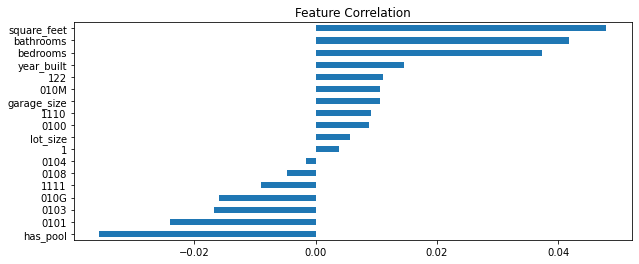

In [63]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation")
corr_chart = (new).corrwith(y_train.log_error).sort_values().plot.barh()
corr_chart